<a href="https://colab.research.google.com/github/Haavi97/ITS8040-NLSP/blob/master/Default_independent_project_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task description

The "default" project topic is about Aspect-Based Sentiment Analysis (ABSA). By "default" it is meant that you are supposed to choose this topic if you don't have any preferences about the topic yourself. You are free to choose any other sufficiently challenging topic, but please consult with the lecturer.

The task comes from the SemEval 2016 Shared Task 5: http://alt.qcri.org/semeval2016/task5/

There are different subtasks and slots in this task. You can limit you work on Task 1 Slot 1: Aspect Category Detection, and you can further focus on the restaurant domain only.

The task is: given a sentence taken from a restaurant review, your system has to decide about which aspect category of the restaurant this sentence is, if any. The number of different aspect categories is fixed. One sentnce can correspond to zero, one or more aspect categories.

Some examples:

*   "I was very disappointed with this restaurant." -> RESTAURANT#GENERAL
*   "I’ve asked a cart attendant for a lotus leaf wrapped rice and she replied back rice and just walked away." -> SERVICE#GENERAL
*   "Chow fun was dry; pork shu mai was more than usually greasy and had to share a table with loud and rude family." -> FOOD#QUALITY, AMBIENCE#GENERAL

The Slot 3 of the task would be finding the polarity (negative, neutral, positive) of the aspect, but you don't have to implement this.

Since the data and evaluation tools for this Shared task come in quite complex form, I have implemented very basic data loading for you, together with a simplest possible sklearn-based implementation for this task.





I have packed the data for the restaurant domain for this subtask on my site. Let's download it:

In [1]:
! wget --no-check-certificate https://www.phon.ioc.ee/~tanela/tmp/absa-en-restaurant.zip

--2021-06-06 03:23:42--  https://www.phon.ioc.ee/~tanela/tmp/absa-en-restaurant.zip
Resolving www.phon.ioc.ee (www.phon.ioc.ee)... 193.40.251.126
Connecting to www.phon.ioc.ee (www.phon.ioc.ee)|193.40.251.126|:443... connected.
  Issued certificate has expired.
	requested host name ‘www.phon.ioc.ee’.
HTTP request sent, awaiting response... 200 OK
Length: 136921 (134K) [application/zip]
Saving to: ‘absa-en-restaurant.zip’

absa-en-restaurant. 100%[===================>] 133.71K   200KB/s    in 0.7s    

2021-06-06 03:23:43 (200 KB/s) - ‘absa-en-restaurant.zip’ saved [136921/136921]



In [2]:
! unzip absa-en-restaurant.zip

Archive:  absa-en-restaurant.zip
  inflating: ABSA16_Restaurants_Train_SB1_v2.xml  
  inflating: EN_REST_SB1_TEST.xml.gold  


There are two files: training and test files. Both are in XML formats. Let's  take a peek:

In [3]:
#! head -20 ABSA16_Restaurants_Train_SB1_v2.xml  

In [4]:
#! head -20 ABSA16_Restaurants_Train_SB1_v2.xml  

There is a lot of information in this XML: each sentence has a list of Opinions, where each Opinion consists of category, polarity and the target word or phrase. We are really interested only in the raw sentence and the corresponding opinion categories.

There are many ways to parse XML in Python. In this example we use a method that parses XML to Python dict, which is we will then process via loops.

In [5]:
! pip install xmltodict

In [6]:
import xmltodict as xd


with open('EN_REST_SB1_TEST.xml.gold','rb') as f:
    d = xd.parse(f)

In [7]:
d["Reviews"]["Review"][0]["sentences"]["sentence"][0]

OrderedDict([('@id', 'en_BlueRibbonSushi_478218171:0'),
             ('text', 'Yum!'),
             ('Opinions',
              OrderedDict([('Opinion',
                            OrderedDict([('@target', 'NULL'),
                                         ('@category', 'FOOD#QUALITY'),
                                         ('@polarity', 'positive'),
                                         ('@from', '0'),
                                         ('@to', '0')]))]))])

Here is the function that parses the XML and returns a list containing sentences and the corresponding list of categories:

In [8]:
def read_data(filename):
  result = []
  with open(filename,'rb') as f:
    d = xd.parse(f, force_list=('sentence', 'Opinion'))
  for review in d["Reviews"]["Review"]:
    #print(review)
    for sentence in review["sentences"]["sentence"]:
      
      text = sentence["text"]
      opinion_cats = []
      
      if "Opinions" in sentence and sentence["Opinions"] is not None:
        opinions = sentence["Opinions"]["Opinion"]
        for opinion in opinions:
          opinion_cats.append(opinion["@category"])
      result.append((text, opinion_cats))
  return result



In [9]:
train_data = read_data("ABSA16_Restaurants_Train_SB1_v2.xml")
test_data = read_data("EN_REST_SB1_TEST.xml.gold")

In [10]:
print(len(train_data), len(test_data))

2000 676


In [11]:
#train_data[:5]

# Pipelines

## Multilabel binarizer

So, each sentence can have zero or more categories. This task is called multi-label classification, as opposed to single-label classification where each sample corresponds to one and only one category.

The sklearn package has some useful utilities for multi-label classification tasks.

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer

MultiLabelBinarizer builds a mapping from multi-label labels to IDs, and also constructs a label matrix for our training ans test data.

In [13]:
mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform([set(sample[1]) for sample in train_data])

In [14]:
train_labels[0:5]

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [15]:
mlb.classes_

array(['AMBIENCE#GENERAL', 'DRINKS#PRICES', 'DRINKS#QUALITY',
       'DRINKS#STYLE_OPTIONS', 'FOOD#PRICES', 'FOOD#QUALITY',
       'FOOD#STYLE_OPTIONS', 'LOCATION#GENERAL', 'RESTAURANT#GENERAL',
       'RESTAURANT#MISCELLANEOUS', 'RESTAURANT#PRICES', 'SERVICE#GENERAL'],
      dtype=object)

In [16]:
#print(test_data)

In [17]:
test_labels = mlb.transform([set(sample[1]) for sample in test_data])

In [18]:
test_labels[0:5]

array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

So, our labels are now stored as binary matrices -- exactly as we need them.

Let's also construct a list of training inputs, as sklearn likes it:

In [19]:
train_text = [review[0] for review in train_data]
test_text = [review[0] for review in test_data]

In [20]:
train_text[0:5]

['Judging from previous posts this used to be a good place, but not any longer.',
 'We, there were four of us, arrived at noon - the place was empty - and the staff acted like we were imposing on them and they were very rude.',
 'They never brought us complimentary noodles, ignored repeated requests for sugar, and threw our dishes on the table.',
 'The food was lousy - too sweet or too salty and the portions tiny.',
 'After all that, they complained to me about the small tip.']

## Data shape

Printing data to have a clear picture.

In [21]:
print('Train text data is of type: {}'.format(type(train_text)))
print('Train label data is of type: {}'.format(type(train_labels)))
print('Train text size: {}'.format(len(train_text)))
print('Test text size: {}'.format(len(test_text)))
print('Train labels size: {}'.format(train_labels.shape))
print('Test labels size: {}'.format(test_labels.shape))
n_labels = test_labels.shape[1]
print('Number of labels: {}'.format(n_labels))
TAGS = mlb.classes_
print('\nThis are the different labels:')
print(TAGS)

Train text data is of type: <class 'list'>
Train label data is of type: <class 'numpy.ndarray'>
Train text size: 2000
Test text size: 676
Train labels size: (2000, 12)
Test labels size: (676, 12)
Number of labels: 12

This are the different labels:
['AMBIENCE#GENERAL' 'DRINKS#PRICES' 'DRINKS#QUALITY'
 'DRINKS#STYLE_OPTIONS' 'FOOD#PRICES' 'FOOD#QUALITY' 'FOOD#STYLE_OPTIONS'
 'LOCATION#GENERAL' 'RESTAURANT#GENERAL' 'RESTAURANT#MISCELLANEOUS'
 'RESTAURANT#PRICES' 'SERVICE#GENERAL']


## OneVsRestClassifier

Now we can train a simple multi-label classifier.

We use Sklearn's OneVsRestClassifier to do this. This basically builds a seperate base classifier for each of our labels.

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier

text_clf = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf',  OneVsRestClassifier(LogisticRegression()))
 ])

In [23]:
text_clf.fit(train_text, train_labels )

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 OneVsRestClassifier(estimator=LogisticRegression(C=1.0,
                                                                  class_weight=None,
                      

Classifier is trained. Let's first see how can we apply it on test data. What comes out when we feed it some test data?

In [24]:
test_predictions = text_clf.predict(test_text)

In [25]:
test_predictions[0:5]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [26]:
test_labels[0:5]

array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

So, the output of our classifier is also a binary matrix. We can evaluate the performance of our model using F1 measure (which is a geometric mean of precision and recall). 

F1 measure can be computed for each label independently and then merged using either macro or micro averaging. We will use micro-averaging that sums up the individual true positives, false positives, and false negatives of the system for different sets and the apply them to get the statistics. 



In [58]:
from sklearn.metrics import f1_score, classification_report, accuracy_score

In [28]:
f1_score(test_labels,
         test_predictions,
         average='micro')

0.4503441494591937

In [59]:
accuracy_score(test_labels,
         test_predictions)

0.42159763313609466

In [29]:
print(classification_report(test_labels, test_predictions, target_names=mlb.classes_, zero_division=0))

                          precision    recall  f1-score   support

        AMBIENCE#GENERAL       1.00      0.21      0.35        57
           DRINKS#PRICES       0.00      0.00      0.00         3
          DRINKS#QUALITY       0.00      0.00      0.00        21
    DRINKS#STYLE_OPTIONS       0.00      0.00      0.00        12
             FOOD#PRICES       0.00      0.00      0.00        22
            FOOD#QUALITY       0.78      0.54      0.64       226
      FOOD#STYLE_OPTIONS       0.00      0.00      0.00        48
        LOCATION#GENERAL       0.00      0.00      0.00        13
      RESTAURANT#GENERAL       0.84      0.23      0.36       142
RESTAURANT#MISCELLANEOUS       0.00      0.00      0.00        33
       RESTAURANT#PRICES       0.00      0.00      0.00        21
         SERVICE#GENERAL       0.95      0.43      0.60       145

               micro avg       0.84      0.31      0.45       743
               macro avg       0.30      0.12      0.16       743
        

It's now your task to improve this.

You can try a lot of things to make the classifier more accurate. Of course, it's very recommended to try different DNN based approaches. 

Note that there are only 2000 training sentences. This makes the task basically an excercise of transfer learning. You can try using pre-trained word embeddings, pre-trained models like BERT, etc.

Note that the labels have some structure in them. Each label consists of two parts: e.g. FOOD#QUALITY consists of FOOD and QUALITY. Maybe try splitting the labels into two parts and predicting each part independanty? Of course, you need to glue them back up when doing evaluation.

Multi-label classification can be easily handled with neural network models with a model that has one output for each label, but instead of simple cross-entropy, binary cross-entropy has to be used for optimization.

Multi-label classification is a quite popular task and you can find a lot of tutorials on the internet. For example, many many text classification where a text can be assigned many tags (as in StackOverflow) are multi-label tasks.


Check the slides of Lecture 1 on how the final project should look like, what parts it should contain and how it will be graded.




## OneVsOne Classifier

In [30]:
def get_index(l):
  try:
    return list(l).index(1)
  except: 
    #print(l)
    return 13

In [31]:
import numpy as np

def reverse(l):
  result = []
  for e in l:
    zeros = np.zeros(12, int)
    if e != 13:
      zeros[e] = 1
    result.append(zeros)
  return np.array(result)


In [32]:
from sklearn.multiclass import OneVsOneClassifier

text_clf_1vs1 = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf',  OneVsOneClassifier(LogisticRegression()))
 ])
train_labels_1vs1 = list(map(lambda x: get_index(x), train_labels))
text_clf_1vs1.fit(train_text, train_labels_1vs1)

test_predictions = text_clf_1vs1.predict(test_text)

test_predictions = reverse(test_predictions)
print(test_predictions)
test_labels_1vs1 = list(map(lambda x: get_index(x), test_labels))
print(test_predictions)
f1 = f1_score(test_labels,
         test_predictions,
         average='micro')
print('F1: {}'.format(f1))
print(classification_report(test_labels, test_predictions, target_names=mlb.classes_, zero_division=0))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
F1: 0.5303703703703704
                          precision    recall  f1-score   support

        AMBIENCE#GENERAL       0.79      0.47      0.59        57
           DRINKS#PRICES       0.00      0.00      0.00         3
          DRINKS#QUALITY       0.00      0.00      0.00        21
    DRINKS#STYLE_OPTIONS       0.00      0.00      0.00        12
             FOOD#PRICES       0.00      0.00      0.00        22
            FOOD#QUALITY       0.53      0.88      0.66       226
      FOOD#STYLE_OPTIONS       0.00      0.00      0.00        48
        LOCATION#GENERAL       0.00      0.00      0.00        13
      RESTAURANT#GENERAL       0.61      0.56      0.58       142
RESTAURANT#MISCELLANEOUS       0.00      0.00      0.00        33
       RES

In [60]:
accuracy_score(test_labels,
         test_predictions)

0.42159763313609466

## OutputCode

In [67]:
from sklearn.multiclass import OutputCodeClassifier
from sklearn.preprocessing import FunctionTransformer

text_clf_occ = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()), 
     ('to_dense', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
     ('clf',  OutputCodeClassifier(LogisticRegression()))
 ])
train_labels_1vs1 = list(map(lambda x: get_index(x), train_labels))
text_clf_occ.fit(train_text, train_labels)

test_predictions = text_clf_occ.predict(test_text)

test_predictions = reverse(test_predictions)
print(test_predictions)
#test_labels_1vs1 = list(map(lambda x: get_index(x), test_labels))
#print(test_predictions)
f1 = f1_score(test_labels,
         test_predictions,
         average='micro')
print('F1: {}'.format(f1))
print(classification_report(test_labels, test_predictions, target_names=mlb.classes_, zero_division=0))

ValueError: ignored

In [ ]:
accuracy_score(test_labels,
         test_predictions)

# BERT approach
  

## Requirements

In [34]:
!pip install transformers

     |████████████████████████████████| 2.3MB 7.3MB/s 
     |████████████████████████████████| 901kB 35.5MB/s 
     |████████████████████████████████| 3.3MB 50.3MB/s 


In [35]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

import torch 

device = 'cpu'
if torch.cuda.is_available():
  device = torch.device('cuda')

print(device)

cuda


## BERT tokenizer

In [36]:
!pip install transformers

In [37]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

## TextDataset

In [38]:
class TextLabelDataset (Dataset):
    def __init__(self, text, labels, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = text
        self.labels = labels
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, item_idx):
        text = self.text[item_idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length= self.max_len,
            padding = 'max_length',
            return_token_type_ids= False,
            return_attention_mask= True,
            truncation=True,
            return_tensors = 'pt'
          )
        
        input_ids = inputs['input_ids'].flatten()
        attn_mask = inputs['attention_mask'].flatten()
               
        return {
          'input_ids': input_ids ,
          'attention_mask': attn_mask,
          'label_ids':torch.tensor(self.labels[item_idx],dtype= torch.float)
        }

In [39]:
all_text = train_text + test_text
all_text_lengths = map(lambda x: len(tokenizer.tokenize(x)), all_text)
MAX_LEN = max(all_text_lengths) + 2
print(MAX_LEN)

110


In [40]:
train_dataset = TextLabelDataset(train_text, train_labels, tokenizer, MAX_LEN)
test_dataset = TextLabelDataset(test_text, test_labels, tokenizer, MAX_LEN)

## BERT Model

In [41]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel

class MyBertModel(nn.Module):
    def __init__(self, num_classes, device='cpu', finetuning=False, dropout=0.2):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased', 
                                              return_dict=True,
                                              dropout=dropout)

        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
        self.sig = nn.Sigmoid()

        self.device = device
        self.finetuning = finetuning

    def forward(self, x, attn):
        '''
        x: (N, T). int64
        Returns
        enc: (N, T, num_classes)
        '''
        x = x.to(self.device)
        # feed input tokens through BERT
        if self.training and self.finetuning:
            self.bert.train()

            outputs = self.bert(input_ids=x,attention_mask=attn)
        else:
            self.bert.eval()
            with torch.no_grad():
              outputs = self.bert(x)
        logits = self.fc(outputs.pooler_output)

        return self.sig(logits)
    
    def to_labels(self, result, threshold=0.5):
        to_return = torch.empty_like(result)
        for i in range(result.shape[0]):
            for j in range(result.shape[1]):
                if result[i][j] > threshold:
                    to_return[i][j] = 1
                else:
                    to_return[i][j] = 0
        return to_return


## Train function

In [42]:
!pip install sklearn_crfsuite
import sklearn_crfsuite
import sklearn_crfsuite.metrics

     |████████████████████████████████| 747kB 8.2MB/s 


In [43]:
def train(model, num_epochs, train_iter, dev_iter):
  criterion = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

  for epoch in range(1, num_epochs+1):
    print("Epoch %d" % epoch)
    
    for i, batch in enumerate(train_iter):
        model.train()
        x = batch["input_ids"]
        y = batch["label_ids"]
        attn = batch["attention_mask"]

        #print(x.shape)
        #print(y.shape)

        optimizer.zero_grad()
        x = x.to(device)
        attn = attn.to(device)
        logits = model(x, attn) # logits: (N, T, TAGS), y: (N, T)
        #print(logits[0])

        logits = logits.view(-1, logits.shape[-1]) # (N*T, TAGS)
        y = y.to(device)
        #y = y.view(-1)  # (N*T,)
        #logits = logits.view(-1)
        #print(logits.shape)
        #print(y.shape)

        loss = criterion(logits, y)
        loss.backward()

        optimizer.step()


        if i % 10 == 0: # monitoring
            print(f"step: {i}, loss: {loss.item()}")

        if i % 100 == 0: # let's evaluate more frequently than every epoch
            evaluate("test set", dev_iter, model)

## Evaluate function

In [44]:
from sklearn.metrics import classification_report

def evaluate(dataset_name, data_iter, model, full_report=False, threshold=0.5):
  
  model.eval()
  not_started = True
  with torch.no_grad():
    for batch in data_iter:
      x = batch["input_ids"]
      y = batch["label_ids"]
      attn = batch["attention_mask"]
      x = x.to(device)
      y = y.to(device)

      logits = model(x, attn)
      y_pred = logits

      if not_started:
        y_seq = y
        y_pred_seq = logits
        not_started = False
      else:
        #print(y_seq.shape)
        #print(y_pred_seq.shape)
        y_seq = torch.cat((y_seq,y), dim=0)
        y_pred_seq = torch.cat((y_pred_seq, y_pred), dim=0)
  
  y_pred_seq = model.to_labels(y_pred_seq, threshold)
  y_seq = y_seq.cpu()
  y_pred_seq = y_pred_seq.cpu()
  accuracy = sklearn_crfsuite.metrics.flat_accuracy_score(y_seq, y_pred_seq)

  f1 = f1_score(y_seq, y_pred_seq, average='micro')
  
  print('  Evaluation on {} -  acc: {:.4f}%'.format(dataset_name, accuracy))
  print('     F1: {}'.format(f1))
  if full_report:
    print(classification_report(y_seq, y_pred_seq, target_names=list(TAGS)))
  return f1

## Model call

In [45]:
model = MyBertModel(n_labels, device, True).to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Batching

In [46]:
# we use a small batch size, as BERT needs a lot of memory
batch_size = 16

train_iter = DataLoader(dataset=train_dataset,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 num_workers=2)
dev_iter = DataLoader(dataset=test_dataset,
                                 batch_size=batch_size,
                                 shuffle=False,
                                 num_workers=2)

## Training

In [47]:
train(model, 10, train_iter, dev_iter)

Epoch 1
step: 0, loss: 0.6323690414428711
  Evaluation on test set -  acc: 0.6642%
     F1: 0.1121251629726206
step: 10, loss: 0.35711145401000977
step: 20, loss: 0.2886849343776703
step: 30, loss: 0.23942308127880096
step: 40, loss: 0.20956584811210632
step: 50, loss: 0.2251710295677185
step: 60, loss: 0.22649209201335907
step: 70, loss: 0.24752943217754364
step: 80, loss: 0.2346840351819992
step: 90, loss: 0.2279844731092453
step: 100, loss: 0.14824214577674866
  Evaluation on test set -  acc: 0.9327%
     F1: 0.47701149425287365
step: 110, loss: 0.14574801921844482
step: 120, loss: 0.13851922750473022
Epoch 2
step: 0, loss: 0.22587677836418152
  Evaluation on test set -  acc: 0.9402%
     F1: 0.5914069081718618
step: 10, loss: 0.19774268567562103
step: 20, loss: 0.19074836373329163
step: 30, loss: 0.16184227168560028
step: 40, loss: 0.14354544878005981
step: 50, loss: 0.12357757985591888
step: 60, loss: 0.1305272877216339
step: 70, loss: 0.119366854429245
step: 80, loss: 0.157730787

## Evaluation

In [48]:
evaluate("dev", dev_iter, model, full_report=True)

  Evaluation on dev -  acc: 0.9115%
     F1: 0.5952649379932355
                          precision    recall  f1-score   support

        AMBIENCE#GENERAL       0.82      0.72      0.77        57
           DRINKS#PRICES       0.00      0.00      0.00         3
          DRINKS#QUALITY       0.62      0.38      0.47        21
    DRINKS#STYLE_OPTIONS       0.80      0.33      0.47        12
             FOOD#PRICES       0.64      0.73      0.68        22
            FOOD#QUALITY       0.77      0.75      0.76       226
      FOOD#STYLE_OPTIONS       0.61      0.40      0.48        48
        LOCATION#GENERAL       0.89      0.62      0.73        13
      RESTAURANT#GENERAL       0.26      0.95      0.41       142
RESTAURANT#MISCELLANEOUS       0.58      0.21      0.31        33
       RESTAURANT#PRICES       0.56      0.48      0.51        21
         SERVICE#GENERAL       0.84      0.77      0.80       145

               micro avg       0.51      0.71      0.60       743
          

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5952649379932355

# Iterative search

## Model call

In [49]:
model2 = MyBertModel(n_labels, device, True).to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Train function

In [50]:
def train(model, num_epochs, train_iter, dev_iter, threshold,
          learning_rate=0.0001):
  criterion = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  f1_epochs = []
  for epoch in range(1, num_epochs+1):
    print("Epoch %d" % epoch)
    
    for i, batch in enumerate(train_iter):
        model.train()
        x = batch["input_ids"]
        y = batch["label_ids"]
        attn = batch["attention_mask"]

        optimizer.zero_grad()
        x = x.to(device)
        attn = attn.to(device)
        logits = model(x, attn) 

        logits = logits.view(-1, logits.shape[-1]) # (N*T, TAGS)
        y = y.to(device)

        loss = criterion(logits, y)
        loss.backward()

        optimizer.step()
    f1_epochs.append(evaluate("test set", dev_iter, model))

  return f1_epochs

## Iterative learning rate

In [ ]:
import numpy as np

lrs = [0.00006, 0.00007, 0.00008, 0.00009,  0.0001, 0.00011, 0.00015] # already from 0.005 F1 gets 0 all the time
thrs = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
results = np.zeros((len(lrs), len(thrs)))
results_epochs = [[[]*len(lrs)]*len(thrs)]
i, j = 0, 0
for lr in lrs:
    j = 0
    for th in thrs:
        #model2 = MyBertModel(n_labels, device, True).to(device)
        print(('***********\n' + \
              'Current iteration:\n' + \
              '\tLearning rate:\t{}\n'+ \
              '\tThreshold:\t{}\n'+ \
              '***********').format(lr, th))
        #results_epochs[i][j] = train(model2, 10, train_iter, dev_iter, 
              #                       th, learning_rate=lr)
        j += 1
    i += 1
#results = list(map(lambda x: max(x), results_epochs))
#print(results)
#print(results_epochs)

## Plotting

In [ ]:
from matplotlib import pyplot as plt
try:
    for i in range(len(results)):
        plt.plot(thrs,results[i][:], label=str(lrs[i]))

    plt.title('Training history')
    plt.ylabel('F1 score')
    plt.xlabel('Threshold value')
    plt.legend()
    plt.show()
except:
    print('Could not plot')

## Training with found parameters

In [53]:
model3 = MyBertModel(n_labels, device, True).to(device)
results = train(model3, 100, train_iter, dev_iter, 0.6, learning_rate=0.00006)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1
  Evaluation on test set -  acc: 0.9294%
     F1: 0.4649859943977591
Epoch 2
  Evaluation on test set -  acc: 0.9467%
     F1: 0.6499189627228525
Epoch 3
  Evaluation on test set -  acc: 0.9490%
     F1: 0.6820276497695853
Epoch 4
  Evaluation on test set -  acc: 0.9486%
     F1: 0.6708760852407262
Epoch 5
  Evaluation on test set -  acc: 0.9432%
     F1: 0.6791927627000696
Epoch 6
  Evaluation on test set -  acc: 0.9540%
     F1: 0.7337615988579586
Epoch 7
  Evaluation on test set -  acc: 0.9402%
     F1: 0.6844502277163305
Epoch 8
  Evaluation on test set -  acc: 0.9534%
     F1: 0.7322946175637393
Epoch 9
  Evaluation on test set -  acc: 0.9492%
     F1: 0.715076071922545
Epoch 10
  Evaluation on test set -  acc: 0.9501%
     F1: 0.7019867549668874
Epoch 11
  Evaluation on test set -  acc: 0.9446%
     F1: 0.6849122807017544
Epoch 12
  Evaluation on test set -  acc: 0.9463%
     F1: 0.7190721649484537
Epoch 13
  Evaluation on test set -  acc: 0.9393%
     F1: 0.6643929058663

In [54]:
evaluate("dev", dev_iter, model3, full_report=True)

  Evaluation on dev -  acc: 0.9167%
     F1: 0.6261061946902655
                          precision    recall  f1-score   support

        AMBIENCE#GENERAL       0.50      0.74      0.60        57
           DRINKS#PRICES       0.33      0.33      0.33         3
          DRINKS#QUALITY       0.56      0.48      0.51        21
    DRINKS#STYLE_OPTIONS       0.37      0.83      0.51        12
             FOOD#PRICES       0.77      0.45      0.57        22
            FOOD#QUALITY       0.76      0.85      0.80       226
      FOOD#STYLE_OPTIONS       0.70      0.29      0.41        48
        LOCATION#GENERAL       0.67      0.77      0.71        13
      RESTAURANT#GENERAL       0.36      0.91      0.51       142
RESTAURANT#MISCELLANEOUS       0.20      0.24      0.22        33
       RESTAURANT#PRICES       0.39      0.86      0.54        21
         SERVICE#GENERAL       0.66      0.83      0.74       145

               micro avg       0.53      0.76      0.63       743
          

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6261061946902655

No handles with labels found to put in legend.


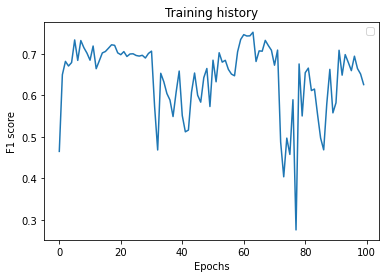

In [56]:
from matplotlib import pyplot as plt

plt.plot(results)
plt.title('Training history')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Predictor

In [ ]:
def return_true(x, y):
  if x:
    return y
  else:
    return ''

  
def predictor(model, text, threshold=0.6):
    model.eval()
    inputs = tokenizer.encode_plus(
        text,
        None,
        add_special_tokens=True,
        max_length= MAX_LEN,
        padding = 'max_length',
        return_token_type_ids= False,
        return_attention_mask= True,
        truncation=True,
        return_tensors = 'pt'
      )
    
    input_ids = inputs['input_ids'].flatten()
    attn_mask = inputs['attention_mask'].flatten()

    output = model(input_ids, attn_mask)
    labels = model.to_labels(output, threshold)
    return list(map(lambda x, y: y if x else '', labels, TAGS))

Some examples:

*   "I was very disappointed with this restaurant." -> RESTAURANT#GENERAL
*   "I’ve asked a cart attendant for a lotus leaf wrapped rice and she replied back rice and just walked away." -> SERVICE#GENERAL
*   "Chow fun was dry; pork shu mai was more than usually greasy and had to share a table with loud and rude family." -> FOOD#QUALITY, AMBIENCE#GENERAL

In [ ]:
test1 = "I was very disappointed with this restaurant."
test2 = "I’ve asked a cart attendant for a lotus leaf wrapped rice and she replied back rice and just walked away."
test3 = "Chow fun was dry; pork shu mai was more than usually greasy and had to share a table with loud and rude family."

print(predictor(model3, test1)) # RESTAURANT#GENERAL
print(predictor(model3, test2)) # SERVICE#GENERAL
print(predictor(model3, test3)) # FOOD#QUALITY, AMBIENCE#GENERAL